In [1]:
from __future__ import division, print_function
import sys, os, glob, time, warnings, gc
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, vstack, hstack
import fitsio
# from astropy.io import fits

In [2]:
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large',
         'figure.facecolor':'w'} 
plt.rcParams.update(params)

In [21]:
columns = ['BRICKID', 'OBJID', 'TYPE', 'RA', 'DEC', 'EBV', 
          'FLUX_G', 'FLUX_R', 'FLUX_Z', 'FLUX_W1', 'FLUX_W2', 'FLUX_IVAR_G', 'FLUX_IVAR_R', 'FLUX_IVAR_Z', 'FLUX_IVAR_W1', 'FLUX_IVAR_W2', 
          'MW_TRANSMISSION_G', 'MW_TRANSMISSION_R', 'MW_TRANSMISSION_Z', 'MW_TRANSMISSION_W1', 'MW_TRANSMISSION_W2', 
          'NOBS_G', 'NOBS_R', 'NOBS_Z', 'NOBS_W1', 'NOBS_W2', 
          'FIBERFLUX_G', 'FIBERFLUX_R', 'FIBERFLUX_Z', 'FIBERTOTFLUX_G', 'FIBERTOTFLUX_R', 'FIBERTOTFLUX_Z', 
          'GAIA_PHOT_G_MEAN_MAG', 'MASKBITS']

3376243


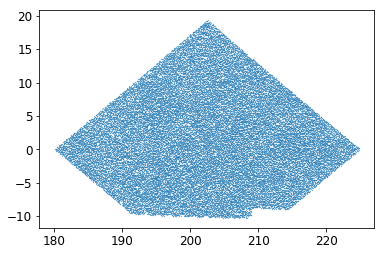

In [21]:
cat = Table(fitsio.read('/global/cscratch1/sd/adamyers/dr9m-partial-sweep/drX/0.42.0/targets/main/resolve/dark/targets-dark-hp-25.fits', 
                        columns=['RA', 'DEC']))
print(len(cat))
plt.plot(cat['RA'][::100], cat['DEC'][::100], '.', ms=0.5)
plt.show()

In [23]:
field = 'south'

target_class = 'ELG'
target_bits = {'LRG':0, 'ELG':1, 'QSO':2, 'BGS_ANY':60}
target_bit = target_bits[target_class]
target_columns = ['BRICKID', 'BRICK_OBJID', 'MORPHTYPE', 'RA', 'DEC', 'EBV', 'FLUX_G', 'FLUX_R', 'FLUX_Z', 'MW_TRANSMISSION_G', 'MW_TRANSMISSION_R', 'MW_TRANSMISSION_Z', 'NOBS_G', 'NOBS_R', 'NOBS_Z', 'FLUX_W1', 'FLUX_W2', 'MW_TRANSMISSION_W1', 'MW_TRANSMISSION_W2', 'WISEMASK_W1', 'WISEMASK_W2', 'MASKBITS', 'PHOTSYS', 'DESI_TARGET']

if field=='south':
    region = 'S'
else:
    region = 'N'

In [26]:
target_path = '/global/cscratch1/sd/adamyers/dr9m-partial-sweep/drX/0.42.0/targets/main/resolve/dark/targets-dark-hp-25.fits'
cat = Table(fitsio.read(target_path, columns=target_columns))
mask = ((cat["DESI_TARGET"] & (2**target_bit))!=0) & (cat['PHOTSYS']==region)

print(np.sum(mask), np.sum(mask)/len(mask))
cat = cat[mask]

2245511 0.665091641804


In [27]:
maskbits = [1, 5, 6, 7, 8, 9, 11, 12, 13]

mask_clean = np.ones(len(cat), dtype=bool)
for bit in maskbits:
    mask_clean &= (cat['MASKBITS'] & 2**bit)==0
print('{:} ({:.1f}%) objects removed by maskbits'.format(np.sum(~mask_clean), np.sum(~mask_clean)/len(mask_clean)*100))
cat = cat[mask_clean]
print(len(cat))

20913 (0.9%) objects removed by maskbits
2224598


In [31]:
mask = (cat['DEC']>0) & (cat['DEC']<5)
print(np.sum(mask), np.sum(mask)/len(mask))
cat = cat[mask]

573958 0.25800526657


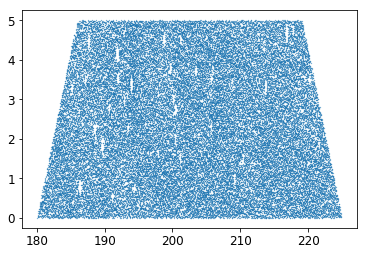

In [34]:
plt.plot(cat['RA'][::10], cat['DEC'][::10], '.', ms=0.5)
plt.show()

In [35]:
tractor_dir = '/global/cfs/cdirs/cosmo/work/legacysurvey/dr9m/south/tractor'
tractor_columns = ['brickid', 'objid', 'flux_z', 'nea_g', 'nea_r', 'nea_z', 'blob_nea_g', 'blob_nea_r', 'blob_nea_z']
columns_to_add = ['tractor_flux_z', 'nea_g', 'nea_r', 'nea_z', 'blob_nea_g', 'blob_nea_r', 'blob_nea_z']

bricks = Table.read('/global/project/projectdirs/cosmo/data/legacysurvey/dr8/survey-bricks.fits.gz')

In [36]:
for col in columns_to_add:
    cat[col] = -99.

In [37]:
brickid_list = np.unique(cat['BRICKID'])
print(len(brickid_list))
for ii, brickid in enumerate(brickid_list):
    
    if ii%100==0:
        print(ii, len(brickid_list))
    
    brick_mask = cat['BRICKID']==brickid
    brickname = bricks['BRICKNAME'][bricks['BRICKID']==brickid][0]
    tractor_path = os.path.join(tractor_dir, '{}/tractor-{}.fits'.format(brickname[:3], brickname))
    tractor = Table(fitsio.read(tractor_path, columns=tractor_columns))
    mask = np.in1d(tractor['objid'], cat['BRICK_OBJID'][brick_mask])
    tractor = tractor[mask]

    t1_reverse_sort = np.array(cat['BRICK_OBJID'][brick_mask]).argsort().argsort()
    tractor.sort('objid')
    tractor = tractor[t1_reverse_sort]
    tractor.rename_column('flux_z', 'tractor_flux_z')
    
    for col in columns_to_add:
        cat[col][brick_mask] = tractor[col]

3287
0 3287
100 3287
200 3287
300 3287
400 3287
500 3287
600 3287
700 3287
800 3287
900 3287
1000 3287
1100 3287
1200 3287
1300 3287
1400 3287
1500 3287
1600 3287
1700 3287
1800 3287
1900 3287
2000 3287
2100 3287
2200 3287
2300 3287
2400 3287
2500 3287
2600 3287
2700 3287
2800 3287
2900 3287
3000 3287
3100 3287
3200 3287


In [38]:
np.all(cat['FLUX_Z']==cat['tractor_flux_z'])

True

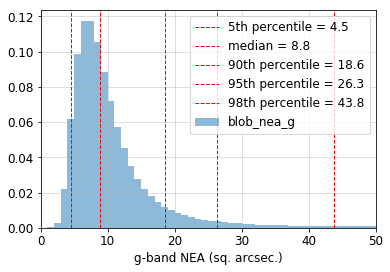

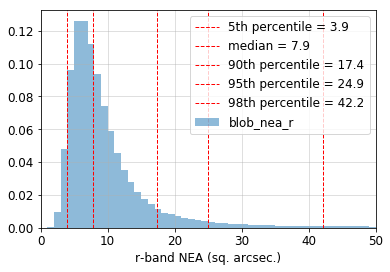

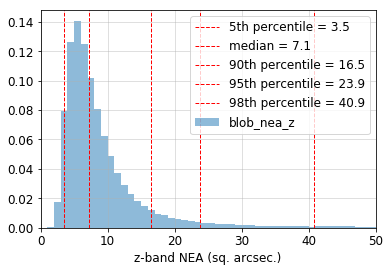

In [91]:
for col in ['nea_g', 'nea_r', 'nea_z']:
    # plt.hist(cat[col], 100, range=(0, 50), alpha=0.5, label=col)
    col1 = col.replace('nea', 'blob_nea')
    plt.hist(cat[col1], 50, range=(0, 50), alpha=0.5, label=col1, density=True)
    percentile = 5
    v = np.percentile(cat[col1], percentile)
    plt.axvline(v, label='{}th percentile = {:.1f}'.format(percentile, v), lw=1, color='r', ls='--')
    v = np.median(cat[col1])
    plt.axvline(v, label='median = {:.1f}'.format(v), lw=1, color='r', ls='--')
    percentile = 90
    v = np.percentile(cat[col1], percentile)
    plt.axvline(v, label='{}th percentile = {:.1f}'.format(percentile, v), lw=1, color='r', ls='--')
    percentile = 95
    v = np.percentile(cat[col1], percentile)
    plt.axvline(v, label='{}th percentile = {:.1f}'.format(percentile, v), lw=1, color='r', ls='--')
    percentile = 98
    v = np.percentile(cat[col1], percentile)
    plt.axvline(v, label='{}th percentile = {:.1f}'.format(percentile, v), lw=1, color='r', ls='--')
    plt.grid(alpha=0.5)
    plt.legend(loc='upper right')
    plt.xlabel('{}-band NEA (sq. arcsec.)'.format(col[-1]))
    plt.xlim(0, 50)
    plt.show()

In [44]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    gmag = 22.5 - 2.5*np.log10(cat['FLUX_G']/cat['MW_TRANSMISSION_G'])
    rmag = 22.5 - 2.5*np.log10(cat['FLUX_R']/cat['MW_TRANSMISSION_R'])
    zmag = 22.5 - 2.5*np.log10(cat['FLUX_Z']/cat['MW_TRANSMISSION_Z'])
    w1mag = 22.5 - 2.5*np.log10(cat['FLUX_W1']/cat['MW_TRANSMISSION_W1'])
    w2mag = 22.5 - 2.5*np.log10(cat['FLUX_W2']/cat['MW_TRANSMISSION_W2'])
    
    gmag[~np.isfinite(gmag)] = 100.
    rmag[~np.isfinite(rmag)] = 100.
    zmag[~np.isfinite(zmag)] = 100.
    w1mag[~np.isfinite(w1mag)] = 100.
    w2mag[~np.isfinite(w2mag)] = 100.

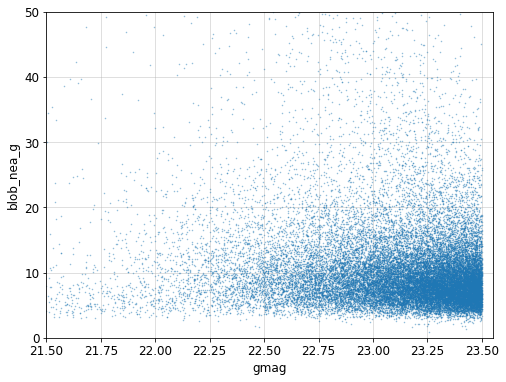

In [102]:
idx = np.random.choice(len(cat), size=int(30000), replace=False)

plt.figure(figsize=(8, 6))
plt.plot(gmag[idx], cat['blob_nea_g'][idx], '.', ms=1, alpha=0.5)
plt.axis([21.5, 23.55, 0, 50])
plt.grid(alpha=0.5)
plt.xlabel('gmag')
plt.ylabel('blob_nea_g')
plt.show()